In [150]:
import sklearn,math, itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler
import time
from joblib import dump, load

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score

import warnings
import matplotlib.pyplot as pyplot

In [ ]:
MODEL = LogisticRegression(solver='saga', tol=1e-2, max_iter=200)
N_SAMPLES_PER_CLASS = 40_000
N_FEATURES_TO_SELECT = 36

In [151]:
x_test = pd.read_csv("../evaluation/X_test.csv")

x_test = x_test[x_test["winner"] != "Draw"]
y_test = x_test["winner"] != "Black"
x_test = x_test[x_test.columns[4:]]

data = pd.read_csv("../evaluation/X_train.csv")
data = data.drop_duplicates(subset=['fen'], keep='last').reset_index(drop=True)

feature_cols = data.columns[4:]


In [152]:
data.describe()

,move number,total moves,W_material sum,W_pawn control,W_piece squares sum,W_diagonal control,W_center control,W_doubled pawns,W_mobility,W_both bishops,...,B_piece squares sum,B_diagonal control,B_center control,B_doubled pawns,B_mobility,B_both bishops,B_not all pawns,B_pinned evaluation,B_attacker evalutation,B_has queen
count,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,...,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000,136596.000000
mean,48.789642,97.704940,25.805097,2.022863,2672.459435,0.352726,4.726405,0.134726,31.186653,0.389016,...,2657.192290,0.423233,4.069197,0.125487,31.186653,0.385597,0.869381,0.139199,3.506750,0.672831
std,35.398250,37.866568,10.729728,0.715864,1148.676549,0.564480,2.022776,0.356454,11.479978,0.487529,...,1146.737038,0.584586,1.789292,0.346945,11.479978,0.486738,0.336984,0.660790,3.297751,0.469649
min,0.000000,10.000000,0.000000,0.000000,-64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,72.000000,17.000000,2.000000,1693.000000,0.000000,3.000000,0.000000,25.000000,0.000000,...,1675.000000,0.000000,3.000000,0.000000,25.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,43.000000,91.000000,28.000000,2.000000,2922.000000,0.000000,5.000000,0.000000,33.000000,0.000000,...,2911.000000,0.000000,4.000000,0.000000,33.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,69.000000,117.000000,35.000000,2.000000,3681.000000,1.000000,6.000000,0.000000,39.000000,1.000000,...,3662.000000,1.000000,5.000000,0.000000,39.000000,1.000000,1.000000,0.000000,5.000000,1.000000
max,429.000000,456.000000,39.000000,4.000000,4226.000000,3.000000,12.000000,3.000000,69.000000,1.000000,...,4238.000000,3.000000,12.000000,4.000000,69.000000,1.000000,1.000000,12.000000,27.000000,3.000000


In [153]:
data_win = data[data["winner"] == "White"]
print(len(data_win))
data_lose = data[data["winner"] == "Black"]
print(len(data_lose))
data_draw = data[data["winner"] == "Draw"]
print(len(data_draw))

data_win = data_win.sample(N_SAMPLES_PER_CLASS)

data_lose = data_lose.sample(N_SAMPLES_PER_CLASS)

data = data_win.append(data_lose)
data.reset_index(drop=True)

51675
41132
43789


,fen,winner,move number,total moves,W_material sum,W_pawn control,W_piece squares sum,W_diagonal control,W_center control,W_doubled pawns,...,B_piece squares sum,B_diagonal control,B_center control,B_doubled pawns,B_mobility,B_both bishops,B_not all pawns,B_pinned evaluation,B_attacker evalutation,B_has queen
0,7k/p5p1/3n3p/8/1p6/1Prb2PP/P5B1/4Q2K w - - 3 33,White,29,84,16,2,1732,1,3,0,...,1601,0,1,0,29,0,1,0,1,0
1,r1b2rk1/1p2qppp/p1np1n2/4p3/4P3/2N1B3/PPP2PPP/...,White,19,141,35,2,3608,0,5,0,...,3647,0,6,0,45,0,1,0,1,1
2,3r2k1/6p1/5p2/3r4/2K1R1Pp/1N5P/1P6/2R5 b - - 0 46,White,38,104,16,1,1508,0,5,0,...,1258,0,5,0,27,0,1,0,0,0
3,6k1/3Pb1p1/p1r3P1/2p2p2/1pN2p2/1P3P2/P5K1/7R w...,White,65,153,13,2,1307,0,2,1,...,1387,0,2,0,33,0,1,0,1,0
4,r2r1n2/pp2nQ2/1kpqP2R/3p3B/8/2N5/PPP5/1K5R w -...,White,67,83,29,1,3111,0,2,0,...,2906,0,5,0,42,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,4r2k/1p3npp/p2q1p2/P1pP4/8/5B1P/1PP2QP1/3R3K b...,Black,31,106,23,2,2444,1,5,0,...,2364,0,4,0,40,0,1,0,1,1
79996,r1b2bk1/ppp3r1/n2p1nq1/1PPPp1pp/2N1Pp2/2N2P2/P...,Black,32,72,39,1,4154,0,8,0,...,3968,0,6,0,34,1,0,0,3,1
79997,1rb2r2/5qbk/p2pp1Rp/2pn1p2/P4P1N/8/1PB3PP/2BQR...,Black,39,80,33,3,3555,0,4,0,...,3543,1,6,0,42,1,1,0,7,1
79998,2r1k2r/1b2b1pp/p2pq3/4p3/p3P3/3B4/PPPB1Q1P/1K1...,Black,91,94,30,3,3148,0,5,1,...,3184,1,6,0,42,1,1,0,3,1


In [154]:
feature_cols = data.columns[4:]

target = data["winner"] != "Black"



features = data[feature_cols]
scaler =  MinMaxScaler()
features_transformed = scaler.fit_transform(features)
features = pd.DataFrame(features_transformed, columns=features.columns)

dump(scaler, 'scaler_FINAL.save') 
x_test = scaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=features.columns)

x_train = features
y_train = target





In [155]:
x_train.describe()

,W_material sum,W_pawn control,W_piece squares sum,W_diagonal control,W_center control,W_doubled pawns,W_mobility,W_both bishops,W_not all pawns,W_pinned evaluation,...,B_piece squares sum,B_diagonal control,B_center control,B_doubled pawns,B_mobility,B_both bishops,B_not all pawns,B_pinned evaluation,B_attacker evalutation,B_has queen
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.673098,0.509088,0.649077,0.117725,0.396307,0.045421,0.464347,0.396400,0.872100,0.009074,...,0.644873,0.144650,0.343044,0.042754,0.464347,0.396925,0.866387,0.012274,0.134170,0.232042
std,0.269186,0.177792,0.261950,0.188295,0.168622,0.119500,0.168449,0.489152,0.333981,0.039465,...,0.259814,0.196975,0.148979,0.116625,0.168449,0.489263,0.340238,0.056585,0.124004,0.153555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.461538,0.500000,0.428671,0.000000,0.250000,0.000000,0.382353,0.000000,1.000000,0.000000,...,0.426214,0.000000,0.250000,0.000000,0.382353,0.000000,1.000000,0.000000,0.037037,0.000000
50%,0.743590,0.500000,0.711189,0.000000,0.416667,0.000000,0.500000,0.000000,1.000000,0.000000,...,0.706949,0.000000,0.333333,0.000000,0.500000,0.000000,1.000000,0.000000,0.111111,0.333333
75%,0.897436,0.500000,0.874359,0.333333,0.500000,0.000000,0.573529,1.000000,1.000000,0.000000,...,0.867999,0.333333,0.416667,0.000000,0.573529,1.000000,1.000000,0.000000,0.185185,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [156]:

estimator = MODEL
selector = RFE(estimator, n_features_to_select=N_FEATURES_TO_SELECT)
selector = selector.fit(x_train, y_train)

support = selector.support_
old_features =x_train.columns
new_features = []

for i in range(len(old_features)):
    if support[i]:
        new_features.append(old_features[i])
    

print(new_features)

x_train = x_train[new_features]
x_test = x_test[new_features]

In [157]:
x_train.describe()

,W_material sum,W_pawn control,W_piece squares sum,W_diagonal control,W_center control,W_doubled pawns,W_mobility,W_both bishops,W_not all pawns,W_pinned evaluation,...,B_piece squares sum,B_diagonal control,B_center control,B_doubled pawns,B_mobility,B_both bishops,B_not all pawns,B_pinned evaluation,B_attacker evalutation,B_has queen
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.673098,0.509088,0.649077,0.117725,0.396307,0.045421,0.464347,0.396400,0.872100,0.009074,...,0.644873,0.144650,0.343044,0.042754,0.464347,0.396925,0.866387,0.012274,0.134170,0.232042
std,0.269186,0.177792,0.261950,0.188295,0.168622,0.119500,0.168449,0.489152,0.333981,0.039465,...,0.259814,0.196975,0.148979,0.116625,0.168449,0.489263,0.340238,0.056585,0.124004,0.153555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.461538,0.500000,0.428671,0.000000,0.250000,0.000000,0.382353,0.000000,1.000000,0.000000,...,0.426214,0.000000,0.250000,0.000000,0.382353,0.000000,1.000000,0.000000,0.037037,0.000000
50%,0.743590,0.500000,0.711189,0.000000,0.416667,0.000000,0.500000,0.000000,1.000000,0.000000,...,0.706949,0.000000,0.333333,0.000000,0.500000,0.000000,1.000000,0.000000,0.111111,0.333333
75%,0.897436,0.500000,0.874359,0.333333,0.500000,0.000000,0.573529,1.000000,1.000000,0.000000,...,0.867999,0.333333,0.416667,0.000000,0.573529,1.000000,1.000000,0.000000,0.185185,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [158]:
scaler =  MinMaxScaler()
features_transformed = scaler.fit_transform(x_train)
x_train = pd.DataFrame(features_transformed, columns=x_train.columns)

dump(scaler, 'scaler_FINAL_Lite.save') 
x_test = scaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=x_train.columns)



In [159]:
x_train.describe()

,W_material sum,W_pawn control,W_piece squares sum,W_diagonal control,W_center control,W_doubled pawns,W_mobility,W_both bishops,W_not all pawns,W_pinned evaluation,...,B_piece squares sum,B_diagonal control,B_center control,B_doubled pawns,B_mobility,B_both bishops,B_not all pawns,B_pinned evaluation,B_attacker evalutation,B_has queen
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.673098,0.509088,0.649077,0.117725,0.396307,0.045421,0.464347,0.396400,0.872100,0.009074,...,0.644873,0.144650,0.343044,0.042754,0.464347,0.396925,0.866387,0.012274,0.134170,0.232042
std,0.269186,0.177792,0.261950,0.188295,0.168622,0.119500,0.168449,0.489152,0.333981,0.039465,...,0.259814,0.196975,0.148979,0.116625,0.168449,0.489263,0.340238,0.056585,0.124004,0.153555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.461538,0.500000,0.428671,0.000000,0.250000,0.000000,0.382353,0.000000,1.000000,0.000000,...,0.426214,0.000000,0.250000,0.000000,0.382353,0.000000,1.000000,0.000000,0.037037,0.000000
50%,0.743590,0.500000,0.711189,0.000000,0.416667,0.000000,0.500000,0.000000,1.000000,0.000000,...,0.706949,0.000000,0.333333,0.000000,0.500000,0.000000,1.000000,0.000000,0.111111,0.333333
75%,0.897436,0.500000,0.874359,0.333333,0.500000,0.000000,0.573529,1.000000,1.000000,0.000000,...,0.867999,0.333333,0.416667,0.000000,0.573529,1.000000,1.000000,0.000000,0.185185,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [160]:
clf = MODEL
clf.fit(x_train, y_train)
dump(clf, 'clf_FINAL_Lite.save') 

LogisticRegression(max_iter=200, solver='saga', tol=0.01)

In [163]:
estimator = clf
train_acc = estimator.score(x_train, y_train)
print(train_acc)

0.65325


In [164]:
test_acc = estimator.score(x_test, y_test)
print(test_acc)

0.6441271339784439


In [165]:
y_pred = estimator.predict(x_test)
y_true = list(y_test)

In [196]:
def predict_with_thresh(x=x_test, y=y_test, thresh=0.55):
    probs = estimator.predict_proba(x_test)
    
    preds = []
    n = len(x)
  
    for i in range(n):
        prediction = probs[i][1] > thresh
        preds.append(prediction)

    return preds

In [197]:
y_pred = predict_with_thresh()
y_true = list(y_test)

Normalized confusion matrix


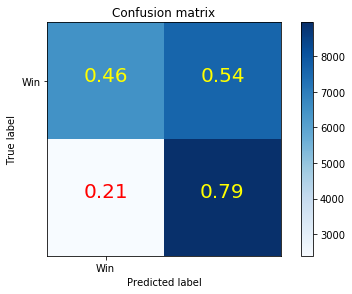

In [198]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                 horizontalalignment="center",
                 color="yellow" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(metrics.confusion_matrix(1 - np.array(y_true),  1 - np.array(y_pred)), classes=["Win"])

In [212]:
def matrix_metrix(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN + FN + TP + FP
    Prevalence = round((TP + FP) / Population, 3)
    Accuracy = round((TP + TN) / Population, 3)
    Precision = round(TP / (TP + FP), 3)
    NPV = round(TN / (TN + FN), 3)
    FDR = round(FP / (TP + FP), 3)
    FOR = round(FN / (TN + FN), 3)
    check_Pos = Precision + FDR
    check_Neg = NPV + FOR
    Recall = round(TP / (TP + FN), 3)
    FPR = round(FP / (TN + FP), 3)
    Specificity = 1 - FPR
    FNR = round(FN / (TP + FN), 3)
    TNR = round(TN / (TN + FP), 3)
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos = round(Recall / FPR, 3)
    LRNeg = round(FNR / TNR, 3)
    DOR = round(LRPos / LRNeg)
    F1 = round(2 * ((Precision * Recall) / (Precision + Recall)), 4)
    F2 = round((1 + 2 ** 2) * ((Precision * Recall) / ((2 ** 2 * Precision) + Recall)), 4)
    F_point_5 = round((1 + 0.5 ** 2) * ((Precision * Recall) / ((0.5 ** 2 * Precision) + Recall)), 4)

    F_point_25 = round((1 + 0.25 ** 2) * ((Precision * Recall) / ((0.25 ** 2 * Precision) + Recall)), 4)
    MCC = -1
#     MCC = round(((TP * TN) - (FP * FN)) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)), 4)
    BM = Recall + TNR - 1
    MK = Precision + NPV - 1
#     AUC = round(metrics.roc_auc_score(y_true, prediction), 3)

    met_dict = {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 'Prevalence': Prevalence,
        'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall,
        'F1': F1, 'F2': F2, 'F0.5': F_point_5, 'F0.25': F_point_25,
        # 'AUC':AUC,
        'NPV': NPV, 'FPR': FPR,
        'TNR': Specificity, 'FNR': FNR, 'TNR': TNR, 'FDR': FDR, 'FOR': FOR, 'check_Pos': check_Pos,
        'check_Neg': check_Neg, 'check_Pos2': check_Pos2, 'check_Neg2': check_Neg2, 'LR+': LRPos,
        'LR-': LRNeg, 'DOR': DOR, 'MCC': MCC, 'BM': BM, 'MK': MK
    }

    return met_dict
pd.DataFrame(matrix_metrix(y_true, y_pred).values(), index=matrix_metrix(y_true, y_pred).keys(), columns=["value"])

,value
TP,6479.0000
TN,8950.0000
FP,2395.0000
FN,7598.0000
Prevalence,0.3490
Accuracy,0.6070
Precision,0.7300
Recall,0.4600
F1,0.5644
F2,0.4967


In [ ]:
prediction = [pos for (neg, pos) in estimator.predict_proba(x_test)]
y_true = y_test
thresholds = [round(i * .01, 2) for i in range(1,100)]

def metric_against_thresholds(metric):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        vals = []
        for t in thresholds:
            y_pred = [1 * (x>=t) for x in prediction]
    
            vals.append(float(matrix_metrix(y_true, y_pred)[metric]))

        return vals

def plot_metrics_against_thresholds(desired_metrics= ["Accuracy","Precision", "Recall", "F1", "F2","F0.5","F0.25"]):
    pyplot.figure(figsize=(14,14))
    pyplot.xlabel("Classification Threshold", fontsize=15)
    pyplot.ylabel("Metric Value", fontsize=15)
    for i in range(len(desired_metrics)):
        pyplot.plot(thresholds, metric_against_thresholds(desired_metrics[i]), lw=3, label=desired_metrics[i])
    pyplot.legend(title="Metrics", fontsize='large')
    pyplot.grid()
    pyplot.show()
plot_metrics_against_thresholds()